## Resampling

<img src="figures/resampling.svg"/><br><br>

Resampling as the verb implies is the action of sampling an image, which itself is a sampling of an original continuous signal.

Generally speaking, resampling in SimpleITK involves four components:
1. Image - the image we resample, given in coordinate system $m$.
2. Resampling grid - a regular grid of points given in coordinate system $f$ which will be mapped to coordinate system $m$.
2. Transformation $T_f^m$ - maps points from coordinate system $f$ to coordinate system $m$, $^mp = T_f^m(^fp)$.
3. Interpolator - method for obtaining the intensity values at arbitrary points in coordinate system $m$ from the values of the points defined by the Image.


While SimpleITK provides a large number of interpolation methods, the two most commonly used are ```sitkLinear``` and ```sitkNearestNeighbor```. The former is used for most interpolation tasks, a compromise between accuracy and computational efficiency. The later is used to interpolate labeled images representing a segmentation, it is the only interpolation approach which will not introduce new labels into the result.

SimpleITK's procedural API provides three methods for performing resampling, with the difference being the way you specify the resampling grid:

1. ```Resample(const Image &image1, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```
2. ```Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```
3. ```Resample(const Image &image1, std::vector< uint32_t > size, Transform transform, InterpolatorEnum interpolator, std::vector< double > outputOrigin, std::vector< double > outputSpacing, std::vector< double > outputDirection, double defaultPixelValue, PixelIDValueEnum outputPixelType)```

In [ ]:
# 0. install
!pip install SimpleITK # install SimpleITK
!git clone https://github.com/kevinkwshin/SimpleITK # for data preparing
%cd SimpleITK

In [1]:
# 1. load library
import SimpleITK as sitk
import numpy as np
import os
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt

OUTPUT_DIR = 'output'

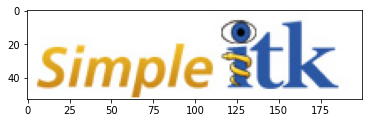

In [2]:
# 2. read image
logo = sitk.ReadImage('data/SimpleITK.jpg')
plt.imshow(sitk.GetArrayViewFromImage(logo))

In [3]:
# 3. define display function
def resample_display(image, euler2d_transform, tx, ty, theta):
    euler2d_transform.SetTranslation((tx, ty))
    euler2d_transform.SetAngle(theta)
    
    resampled_image = sitk.Resample(image, euler2d_transform)
    plt.imshow(sitk.GetArrayFromImage(resampled_image))
    plt.axis('off')    
    plt.show()

# 4. define transform
euler2d = sitk.Euler2DTransform()

# 5. Set Center-point in the center of image 
euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0)) # np.array(logo.GetSize())/2.0 <-- center of (width, height)

# 6. Check the result
interact(resample_display, image=fixed(logo), euler2d_transform=fixed(euler2d), tx=(-128.0, 128.0,2.5), ty=(-64.0, 64.0), theta=(-np.pi/4.0, np.pi/4.0));

interactive(children=(FloatSlider(value=-0.5, description='tx', max=128.0, min=-128.0, step=2.5), FloatSlider(…

### Common Errors

It is not uncommon to end up with an empty (all black) image after resampling. This is due to:
1. Using wrong settings for the resampling grid, not too common, but does happen.
2. Using the inverse of the transformation $T_f^m$. This is a relatively common error, which is readily addressed by invoking the transformations ```GetInverse``` method.

### Defining the Resampling Grid

In the example above we arbitrarily used the original image grid as the resampling grid. As a result, for many of the transformations the resulting image contained black pixels, pixels which were mapped outside the spatial domain of the original image and a partial view of the original image.

If we want the resulting image to contain all of the original image no matter the transformation, we will need to define the resampling grid using our knowledge of the original image's spatial domain and the **inverse** of the given transformation. 

Computing the bounds of the resampling grid when dealing with an affine transformation is straightforward. An affine transformation preserves convexity with extreme points mapped to extreme points. Thus we only need to apply the **inverse** transformation to the corners of the original image to obtain the bounds of the resampling grid.

Computing the bounds of the resampling grid when dealing with a BSplineTransform or DisplacementFieldTransform is more involved as we are not guaranteed that extreme points are mapped to extreme points. This requires that we apply the **inverse** transformation to all points in the original image to obtain the bounds of the resampling grid.  

In [4]:
# 1. check shape of original image
print(logo.GetSize())

(200, 53)


In [5]:
# 2. define transform
euler2d = sitk.Euler2DTransform()

# 3. setting center
euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0)) 

# 4. setting transform
euler2d.SetTranslation((50, 20))

extreme_points = [logo.TransformIndexToPhysicalPoint((0,0)), 
                  logo.TransformIndexToPhysicalPoint((logo.GetWidth(),0)),
                  logo.TransformIndexToPhysicalPoint((logo.GetWidth(),logo.GetHeight())),
                  logo.TransformIndexToPhysicalPoint((0,logo.GetHeight()))]
inv_euler2d = euler2d.GetInverse()

extreme_points_transformed = [inv_euler2d.TransformPoint(pnt) for pnt in extreme_points]
min_x = min(extreme_points_transformed)[0]
min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
max_x = max(extreme_points_transformed)[0]
max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]
print('min_x,min_y,max_x,max_y of translation:',min_x,min_y,max_x,max_y)

min_x,min_y,max_x,max_y of translation: -50.0 -20.0 150.0 33.0


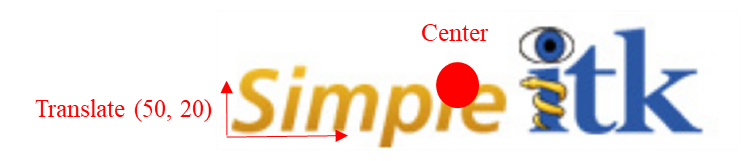

In [6]:
from IPython.display import Image
Image(filename='data/resample_case.png')

# Good case of resampling

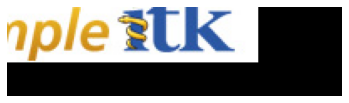

In [13]:
# Use the original spacing (arbitrary decision).
output_spacing = logo.GetSpacing()
# output_spacing = (2,1) ### to change spacing!###

# Identity cosine matrix (arbitrary decision).   
output_direction = [1.0, 0.0, 0.0, 1.0]
# Minimal x,y coordinates are the new origin.
output_origin = [0, 0]
# Compute grid size based on the physical size and spacing.
output_size = [int((max_x-min_x)/output_spacing[0]), int((max_y-min_y)/output_spacing[1])]

resampled_image = sitk.Resample(logo, output_size, euler2d, sitk.sitkLinear, output_origin, output_spacing, output_direction)
plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
plt.axis('off')    
plt.show()

# Bad case of resampling

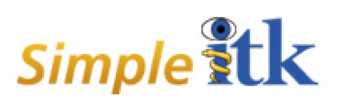

In [12]:
# Use the original spacing (arbitrary decision).
output_spacing = logo.GetSpacing()
# output_spacing = (2,1) ### to change spacing!###

# Identity cosine matrix (arbitrary decision).   
output_direction = [1.0, 0.0, 0.0, 1.0]
# Minimal x,y coordinates are the new origin.
output_origin = [min_x, min_y]
# Compute grid size based on the physical size and spacing.
output_size = [int((max_x-min_x)/output_spacing[0]), int((max_y-min_y)/output_spacing[1])]

resampled_image = sitk.Resample(logo, output_size, euler2d, sitk.sitkLinear, output_origin, output_spacing, output_direction)
plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
plt.axis('off')    
plt.show()

<a href="03_trust_but_verify.ipynb"><h2 align=right>Next &raquo;</h2></a>